# Multiperceptrón - Entrenamiento y Métricas
---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [ ]:
def entorno_de_trabajo():
    if 'google.colab' in str(get_ipython()): return "colab"  # Colab?
    else: return "local"  # Local => Linux, Windows, WSL

if entorno_de_trabajo() == 'colab': # maquina virtual colab
    from google.colab import drive
    drive.mount('/content/drive/')  # monta G-drive en entorno COLAB

    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'  # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else: # entorno local # Rutas relativas al script para entornos locales Windows, WSL y Linux
    FUENTES_DIR = '../../FUENTES/'  # Ajusta según tu estructura
    DATOS_DIR = '../../DATOS/'

import sys
sys.path.append(FUENTES_DIR) # agrega ruta de busqueda donde tenemos archivos .py

Mounted at /content/drive/


In [ ]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos
import numpy as np

from sklearn import preprocessing, model_selection, metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras import optimizers

from matplotlib import pyplot as plt
import plotly.express as px

nombre_archivo = DATOS_DIR + 'iris.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

# Para hacer una inspección rápida de los datos
#print(df.head())
#print(df.describe())
df

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


### Grafica 4 dimensiones en 3D
Utiliza 3 atributos para x, y, z. La cuarta dimensión la grafica como tamaño del círculo

In [ ]:
# grafica ejemplos según propiedades en 3d
px.scatter_3d(df, x="petallength", y="petalwidth", z="sepallength", size="sepalwidth", color="class")

Selección de atributos y target

In [ ]:
# %% separa atributos y clases
X_raw = np.array(df.iloc[:, :4])
Y_raw = np.array(df['class'])
nomClases = df['class'].value_counts()

# Binarizador para convertir el nombre de la clase en one hot encoding
binarizer = preprocessing.LabelBinarizer()

# Binariza cada clase como una combinación de un 1 y 0s
Y_raw = binarizer.fit_transform(Y_raw)
print('Las clases del dataset son :', binarizer.classes_)

# %% Separa ejemplos para enternamiento y testeo
TEST_SIZE = 0.2 # proporcion entre testeo entre entrenamiento y testeo
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_raw, Y_raw, test_size=TEST_SIZE)#, random_state=42)

# Escala los atributos de los ejemplo
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
X_train  = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


print('\nDatos de Entrenamiento: %d   Datos de Testeo: %d' % (len(Y_train), len(Y_test) ))


Las clases del dataset son : ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']

Datos de Entrenamiento: 120   Datos de Testeo: 30


**Definición de funciones para métricas**

In [ ]:
# calcula las metricas precision, recall, f1-score y accuracy a partir de la matriz de confusion
# retorna tupla: ( precision, recall, f1_score, accuracy )
def calcular_metricas(conf_mat):
    precision = np.zeros(conf_mat.shape[0])
    for i in range(0, len(conf_mat)):
        precision[i] = conf_mat[i][i]/sum(conf_mat.T[i])

    recall = np.zeros(conf_mat.shape[0])
    for i in range(0, len(conf_mat)):
        recall[i] = conf_mat[i][i]/sum(conf_mat[i])

    f1_score = 2* (precision*recall) /(precision+recall)

    accuracy =  0
    for i in range(0, len(conf_mat)):
        accuracy+=conf_mat[i][i]
    accuracy/= conf_mat.sum()

    return ( precision, recall, f1_score, accuracy )

# el parámetro metricas es una tupla ( precision, recall, f1_score, accuracy )
def imprimir_metricas( metricas ):
    (precision, recall, f1_score, accuracy) = metricas
    print('\n clase   precision    recall    f1-score')
    for i in range(0, len(precision)):
        print('%5d %10.2f %10.2f %10.2f' % (i, precision[i], recall[i], f1_score[i]))
    print('\naccuracy: %6.2f\n' % accuracy)


**Entrenamiento**

In [ ]:
ENTRADAS = X_train.shape[1]
OCULTAS = 2
SALIDAS  = Y_train.shape[1]
ACTIVACION = 'tanh'   # TF vs SkLearn linear => identity, sigmoid => logistic, tanh => tanh, relu => relu
EPOCAS = 500
TAM_LOTE = 32
ALFA = 0.05

print(X_train.shape)
print(X_test.shape)

modelo = Sequential()
modelo.add(Dense(OCULTAS, activation=ACTIVACION, input_dim=ENTRADAS))
modelo.add(Dense(OCULTAS, activation=ACTIVACION))
modelo.add(Dense(SALIDAS, activation='softmax'))

modelo.summary()

optimizador = optimizers.SGD(learning_rate=ALFA)
# obtiene la arquitectura para el modelo y lo compila
modelo.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics = ['accuracy'])

# Entrena el modelo y guarda la historia del progreso
history = modelo.fit(x=X_train, y=Y_train, batch_size=TAM_LOTE, validation_split=0.25, epochs=EPOCAS)

(120, 4)
(30, 4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.3815 - loss: 1.0468 - val_accuracy: 0.3667 - val_loss: 1.1011
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3229 - loss: 1.0515 - val_accuracy: 0.2667 - val_loss: 1.0893
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3747 - loss: 1.0394 - val_accuracy: 0.4000 - val_loss: 1.0793
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4977 - loss: 1.0371 - val_accuracy: 0.4000 - val_loss: 1.0715
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5016 - loss: 1.0275 - val_accuracy: 0.4000 - val_loss: 1.0649
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4899 - loss: 1.0381 - val_accuracy: 0.4000 - val_loss: 1.0596
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4961 - loss: 1.0279 - val_accuracy: 0.4000 - val_loss: 1.0552
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5352 - loss: 0.9967 - val_accuracy: 0.4000 - val_loss

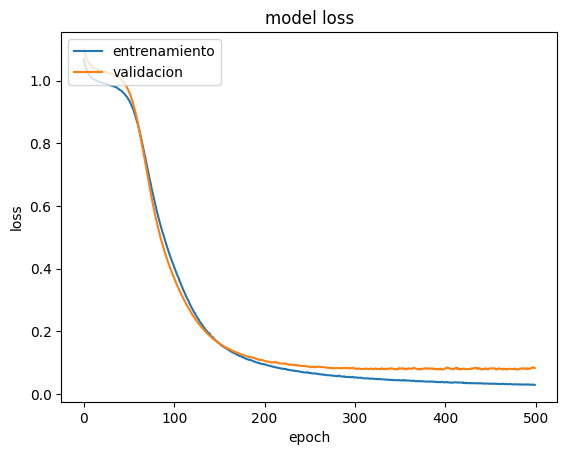

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validacion'], loc='upper left')
plt.show()

In [ ]:
#  ########### Medición del entrenamiento ######################
Y_pred = modelo.predict(X_train)

# "invierte" la transformacion binaria para obtener los nombres de las clases
Y_it = binarizer.inverse_transform(Y_train)
Y_pred_it = binarizer.inverse_transform(Y_pred)

# calculo manual del accuracy
print('Efectividad: %6.2f%%' % (100*(Y_pred_it == Y_it).sum()/len(Y_it)) )

report = metrics.classification_report(Y_it, Y_pred_it)
print("Reporte SkLearn:\n%s" % report)
cm = metrics.confusion_matrix(Y_it, Y_pred_it)
print("Confusion matrix:\n%s" % cm)

#calcula métricas de forma manual
mt = calcular_metricas(cm)
imprimir_metricas(mt)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Efectividad:  99.17%
Reporte SkLearn:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        40
Iris-versicolor       1.00      0.98      0.99        42
 Iris-virginica       0.97      1.00      0.99        38

       accuracy                           0.99       120
      macro avg       0.99      0.99      0.99       120
   weighted avg       0.99      0.99      0.99       120

Confusion matrix:
[[40  0  0]
 [ 0 41  1]
 [ 0  0 38]]

 clase   precision    recall    f1-score
    0       1.00       1.00       1.00
    1       1.00       0.98       0.99
    2       0.97       1.00       0.99

accuracy:   0.99

